In [ ]:
import mne
import os
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.preprocessing import read_ica
from mne.beamformer import apply_lcmv, make_lcmv
from preprocessing import Preprocessing
from mne import compute_raw_covariance
from datahandling import BcomMEG
import matplotlib.pyplot as plt
from wavelets import process_channel

In [2]:
root_local = "/Volumes/BCOM"
root_server = "/pasteur/zeus/projets/p02/BCOM"
root = root_local

In [3]:
empty_room = mne.io.read_raw_fif(
    os.path.join(root, "ciprian_project/data_analyzed/preprocessed/BCOM_01/2/empty_room_cleaned_ICA_raw.fif"),
    preload=True
    )
empty_room.info['bads']
bad_loc_channel = "MEG 173"
empty_room.interpolate_bads(exclude=[bad_loc_channel], origin=(0., 0., 0.))

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/empty_room_cleaned_ICA_raw.fif...
Isotrak not found
    Range : 0 ... 89999 =      0.000 ...   179.998 secs
Ready.
Reading 0 ... 89999  =      0.000 ...   179.998 secs...
Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Computing dot products for 244 MEG channels...
    Computing cross products for 244 → 3 MEG channels...
    Preparing the mapping matrix...
    Truncating at 88/244 components to omit less than 0.0001 (9.6e-05)


<Raw | empty_room_cleaned_ICA_raw.fif, 280 x 90000 (180.0 s), ~192.5 MB, data loaded>

Using up to 900 segments
Using data from preloaded Raw for 900 events and 100 original time points ...
0 bad epochs dropped
Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 90000
log-likelihood on unseen data (descending order):
   shrunk: -1369.447
   diagonal_fixed: -1397.723
   empirical: -1499.945
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 247
    MAG: rank 247 computed from 247 data channels with 0 projectors


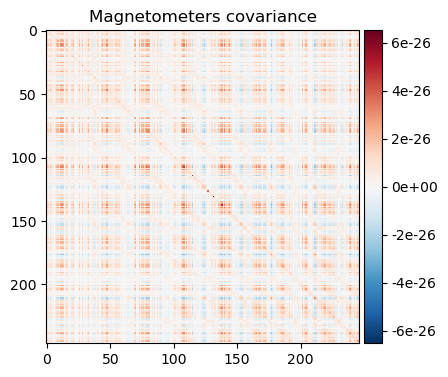

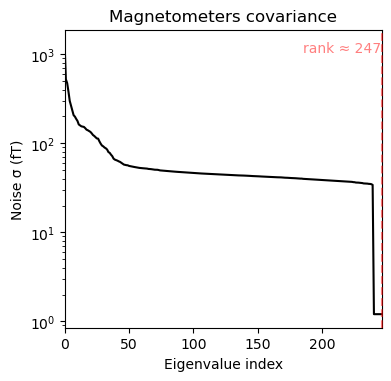

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [4]:
noise_cov = compute_raw_covariance(empty_room, 
                                   method='auto',
                                   rank="info", 
                                   picks="meg")
mne.viz.plot_cov(noise_cov, empty_room.info)

In [164]:
scaled = "scaled_fsaverage"
subject = "BCOM_13_2"

morphed_root_local = "/Users/ciprianbangu/mne_data/MNE-fsaverage-data"
morphed_root_server = "/pasteur/appa/scratch/cbangu/MNE-fsaverage-data"
morphed_root = morphed_root_local
trans_root_local = "/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans"
trans_root_server = "/pasteur/appa/scratch/cbangu/trans"
trans_root = trans_root_local

morphed_bem = os.path.join(morphed_root, f"{scaled}_{subject}/bem/{scaled}_{subject}-5120-5120-5120-bem-sol.fif")
morphed_source = os.path.join(morphed_root, f"{scaled}_{subject}/bem/{scaled}_{subject}-ico-5-src.fif")
morphed_trans = os.path.join(trans_root,f"{subject}-trans.fif")


fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

0 files missing from root.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage


In [175]:
dir_cov = os.path.join(root, 'ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT')
dir_ov = os.path.join(root,'ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/OVERT')
subjects = [subject]
picks = None

data_covert = BcomMEG(dir=dir_cov, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=False)
data_overt = BcomMEG(dir=dir_ov, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=False)

Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_13_2_la_122-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_13_2_re_44-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_13_2_li_126-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
14 matching events found
No baseline correction a

In [176]:
sub = subject[:7]
block = subject[-1]
raw = mne.io.read_raw_fif(fname=os.path.join(root,f"ciprian_project/data_analyzed/preprocessed/{sub}/{block}/subject_cleaned_ica_raw.fif"))
epochs_array = []
dropped_epochs = []

for syl in data_covert.data[subject]:
    if data_covert.data[subject][syl].info['dev_head_t'] != raw.info['dev_head_t']:
        dropped_epochs.append(("Covert", syl, len(data_covert.data[subject][syl].events)))
    else:
        epochs_array.append(data_covert.data[subject][syl])

for syl in data_overt.data[subject]:
    if data_overt.data[subject][syl].info['dev_head_t'] != raw.info['dev_head_t']:
        dropped_epochs.append(("Overt", syl, len(data_covert.data[subject][syl].events)))
    else:
        epochs_array.append(data_overt.data[subject][syl])

epochs_array = mne.concatenate_epochs(epochs_array)

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_13/2/subject_cleaned_ica_raw.fif...
    Range : 0 ... 286562 =      0.000 ...   573.124 secs
Ready.
Not setting metadata
449 matching events found
No baseline correction applied


In [177]:
dropped_epochs

[('Overt', 're_44', 8),
 ('Overt', 'se_154', 5),
 ('Overt', 'sa_152', 13),
 ('Overt', 'sa_52', 13),
 ('Overt', 'mi_36', 11),
 ('Overt', 'i_116', 12),
 ('Overt', 'e_14', 12),
 ('Overt', 'e_114', 12),
 ('Overt', 'i_16', 12),
 ('Overt', 're_144', 8),
 ('Overt', 'mi_136', 11),
 ('Overt', 'se_54', 5)]

In [17]:
data_overt.data[subject]['ti_66'].info['dev_head_t']

<Transform | MEG device->head>
[[ 0.99998695  0.00350168  0.00372768  0.00148638]
 [-0.00451716  0.94650698  0.32265171 -0.03080797]
 [-0.00239845 -0.32266435  0.94651043  0.06309178]
 [ 0.          0.          0.          1.        ]]

In [8]:
data_cov = mne.compute_covariance(epoch_array.copy().crop(tmin=-0.2, tmax=0.6), method='auto', rank="info")

Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 174435
log-likelihood on unseen data (descending order):
   shrunk: -1354.911
   diagonal_fixed: -1406.852
   empirical: -1433.025
selecting best estimator: shrunk
[done]


Computing rank from covariance with rank=None
    Using tolerance 1.4e-13 (2.2e-16 eps * 247 dim * 2.5  max singular value)
    Estimated rank (mag): 247
    MAG: rank 247 computed from 247 data channels with 0 projectors


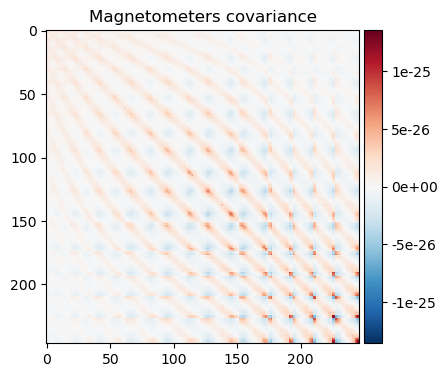

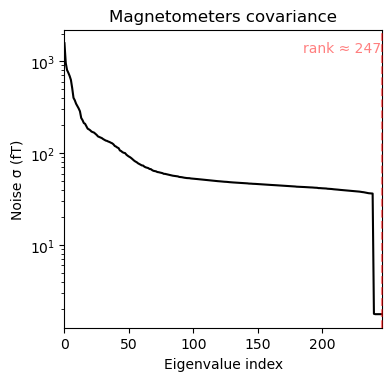

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [9]:
data_cov.plot(epoch_array.info)

In [10]:
forward_model = mne.make_forward_solution(
    epoch_array.info,
    trans=morphed_trans,
    src=morphed_source, 
    bem=morphed_bem, 
    meg=True, 
    eeg=False
)

Source space          : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif
MRI -> head transform : /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/BCOM_01_2-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999667 -0.010944 -0.023385       1.50 mm
    0.010999 0.999937 0.002219      25.63 mm
    0.023359 -0.002476 0.999724      34.46 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil 

In [11]:
filters = make_lcmv(
    epoch_array.info,
    forward_model,
    data_cov,
    reg=0.05,
    noise_cov=noise_cov,
    pick_ori="max-power",
    weight_norm="unit-noise-gain",
    rank="info",
)

Computing rank from covariance with rank='info'
    MAG: rank 247 after 0 projectors applied to 247 channels
Computing rank from covariance with rank='info'
    MAG: rank 247 after 0 projectors applied to 247 channels
Making LCMV beamformer with rank {'mag': 247}
Computing inverse operator with 247 channels.
    247 out of 247 channels remain after picking
Selected 247 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 247}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 20484 sources
Filter computation complete


In [12]:
filters

<Beamformer | LCMV, subject "scaled_fsaverage_BCOM_01_2", 20484 vert, 247 ch, max-power ori, unit-noise-gain norm, matrix inversion, rank 247>

In [13]:
vts_native = mne.beamformer.apply_lcmv_epochs(epoch_array[0], filters)

Processing epoch : 1
[done]


In [20]:
stcs_nat = []
for vt in vts_native:
    stcs_nat.append(vt.crop(-0.2, 0.6))

In [26]:
from mne import compute_source_morph

morph = compute_source_morph(
    src=morphed_source,
    subject_from=f"{scaled}_{subject}",
    subject_to='fsaverage',
    subjects_dir=subjects_dir,
)

Reading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    2 smooth iterations done.
    2 smooth iterations done.
[done]
[done]


In [27]:
stcs_fs = [morph.apply(stc) for stc in stcs_nat]

In [64]:
brain = stcs_fs[0].plot()
brain.add_label(sma_labels)

Using control points [2.4886481  2.90134243 6.58393044]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e1693060> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3f930af60> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3f938bdf0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3f938d220> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3f9391e40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3f93930e0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3f9393a80> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [61]:
labels_hcp = mne.read_labels_from_annot(
    subject="fsaverage",
    parc="HCPMMP1",
)

Reading labels from parcellation...
   read 181 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.HCPMMP1.annot
   read 181 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/rh.HCPMMP1.annot


In [62]:
sma_labels = [label for label in labels_hcp if 'L_6ma_ROI-lh' in label.name][0] +\
        [label for label in labels_hcp if 'L_6mp_ROI-lh' in label.name][0] +\
        [label for label in labels_hcp if 'L_SCEF_ROI-lh' in label.name][0] +\
        [label for label in labels_hcp if 'L_SFL_ROI-lh' in label.name][0]

In [32]:
from mne import extract_label_time_course
fs_average_source_space = mne.setup_source_space(
    subject='fsaverage', # only once, no co-registration
    spacing='ico5',
    add_dist=False,
)


ts = extract_label_time_course(
    stcs_fs,
    sma_labels,
    src=fs_average_source_space,
    mode="mean_flip",
    return_generator=False,
)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/ciprianbangu/mne_data/MNE-fsaverage-data
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 10242/163842 selected to source space (ico = 5)

Loading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 

In [180]:
ts[0].shape

(1, 401)

In [ ]:
result = 

In [ ]:
import pywt
import numpy as np
from wavelets import *
sampling_rate = 500 # data already downsampled to 300 at this point
log_samples = 100 # we want 100 coefficients
cwt_wavelet_name = 'cmor' # reconstruction wavelet
B = 1.0 # wavelet bandwith (higher means more frequencies at each scale, but less precision in peak timing)
C = 1.0 # central frequency (higher means more oscialltions per time window, meaning higher frequency features per scale)
cwt_wavelet = f'{cwt_wavelet_name}{B}-{C}'
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
sampling_period = 1/sampling_rate
scales = pywt.central_frequency(wavelet=cwt_wavelet)/ (frequencies * sampling_period)
dwt_wavelet_name='db4' # denoizing wavelet 
level=5 # level of decomposition. NB in Dash et al. they use 7, but our signal is shorter, so 5 is max

In [183]:
for j, tc in enumerate(ts):
    result = process_channel(
        signal=tc,
        cwt_wavelet=cwt_wavelet,
        scales=scales,
        sampling_period=sampling_period,
        dwt_wavelet_name=dwt_wavelet_name,
        level=level,
    )

In [191]:
tc.shape

(1, 401)

In [186]:
result.shape

reshaped_result = np.transpose(result, (0, 2, 1))

In [189]:
reshaped_result = reshaped_result.squeeze()

In [192]:
reshaped_result = reshaped_result[:, :tc.shape[1]]

In [196]:
reshaped_result.shape

(100, 401)

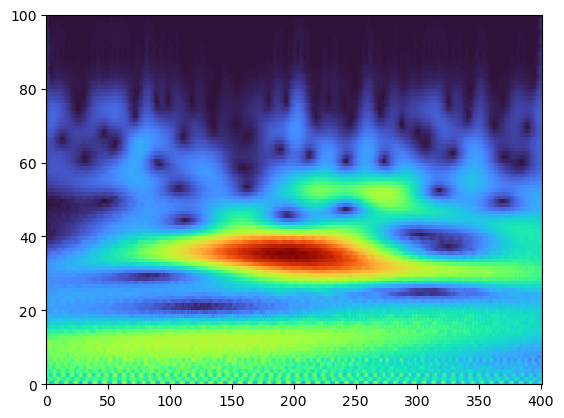

In [92]:
plt.pcolormesh(x, cmap='turbo')

In [159]:
subject = "BCOM_18_2"
subjects = [subject]
data_covert_reading = BcomMEG(dir=dir_cov, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=True)

Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_18_2_i_16-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_18_2_me_34-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_18_2_sa_52-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
13 matching events found
No baseline correction app

In [160]:
evoked = [data_covert_reading.data[subject][syl] for syl in data_covert_reading.data[subject]]

In [161]:
evoked = mne.concatenate_epochs(evoked)
evoked = evoked.average() 

Not setting metadata
207 matching events found
No baseline correction applied


In [162]:
stcs_ev = apply_lcmv(evoked, filters)

In [163]:
brain = stcs_ev.plot()
brain.add_label(sma_labels)

Using control points [17.01812676 18.97876071 30.37176529]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e4a17270> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdd3cb0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3640119e0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdce6e0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdc58f0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdc4a80> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdc5110> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e4a17270> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdd3cb0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3640119e0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdce6e0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdc58f0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdc4a80> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3dbdc5110> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [197]:
baseline = mne.io.read_raw_fif(fname="/Volumes/BCOM/ciprian_project/data_analyzed/baselines/BCOM_01/BCOM_01_2_baseline_raw.fif")

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/baselines/BCOM_01/BCOM_01_2_baseline_raw.fif...
    Range : 18384 ... 32784 =     36.768 ...    65.568 secs
Ready.


In [199]:
baseline_beam = mne.beamformer.apply_lcmv_raw(baseline, filters)

In [203]:
morphed_baseline = morph.apply(baseline_beam)

In [205]:
label_time_course_baseline = mne.extract_label_time_course(
    morphed_baseline,
    sma_labels,
    src=fs_average_source_space,
    mode="mean_flip",
    return_generator=False,
)

Extracting time courses for 1 labels (mode: mean_flip)


In [207]:
baseline_tf = process_channel(
    signal=label_time_course_baseline,
    cwt_wavelet=cwt_wavelet,
    scales=scales,
    sampling_period=sampling_period,
    dwt_wavelet_name=dwt_wavelet_name,
    level=level,
)

In [211]:
reshaped_baseline = np.transpose(baseline_tf, (0, 2, 1))
reshaped_baseline = reshaped_baseline.squeeze()
reshaped_baseline = reshaped_baseline[:, :label_time_course_baseline.shape[1]]

In [215]:
baseline_row_mean = reshaped_baseline.mean(axis=1, keepdims=True)
baseline_row_std = reshaped_baseline.std(axis=1, keepdims=True)

In [217]:
x.shape

(100, 401)

In [ ]:
x = (x - baseline_row_mean) / baseline_row_std

In [3]:
x = np.load("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/BCOM_01_2_ma_132_coefficients.npy", mmap_mode='r')

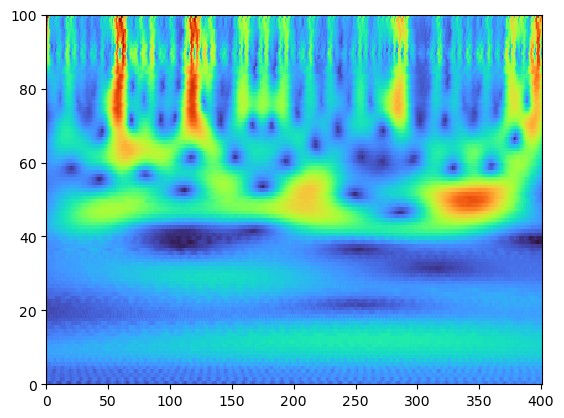

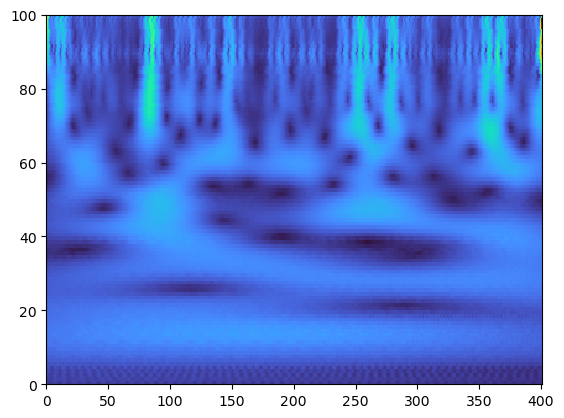

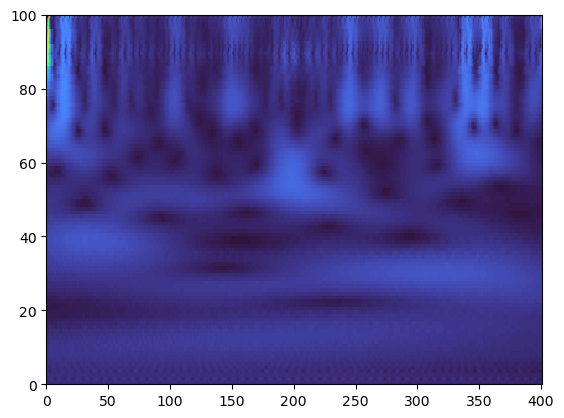

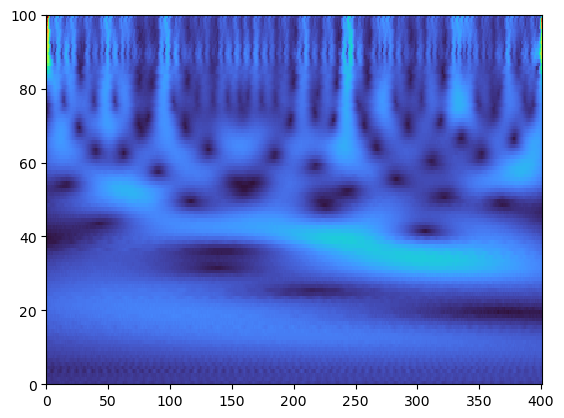

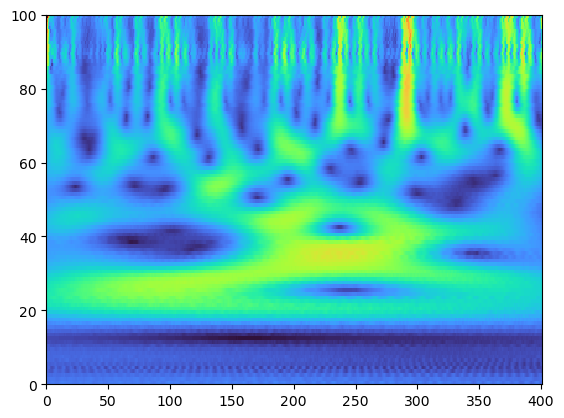

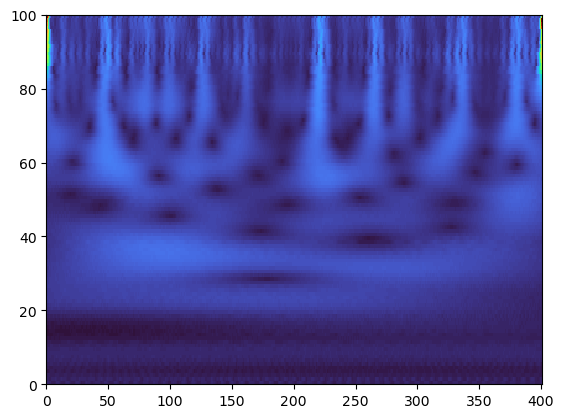

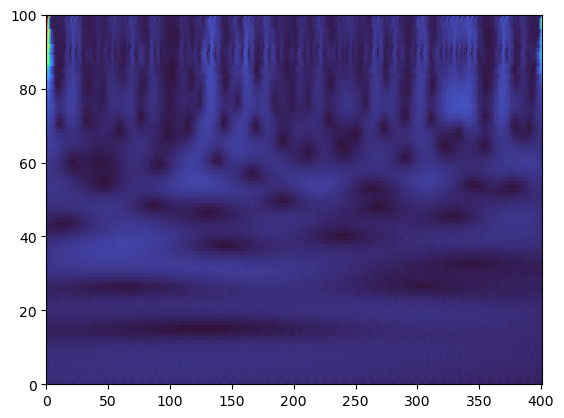

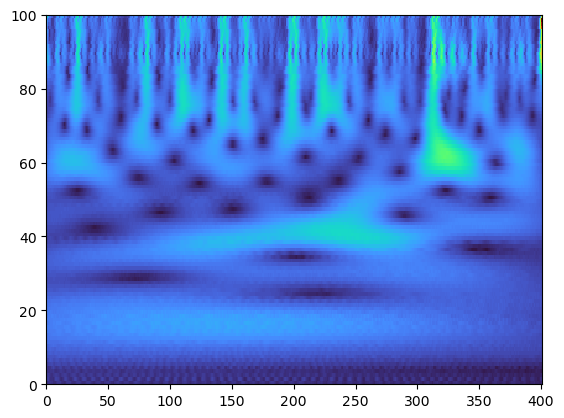

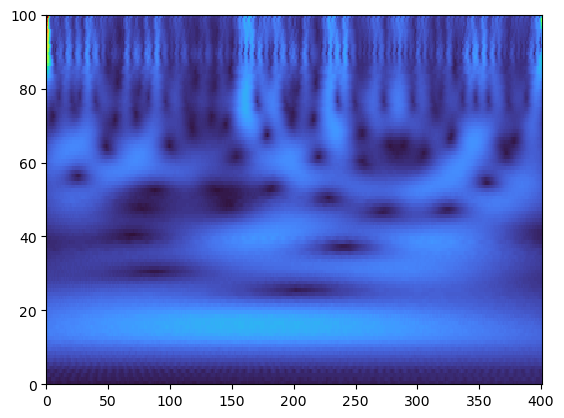

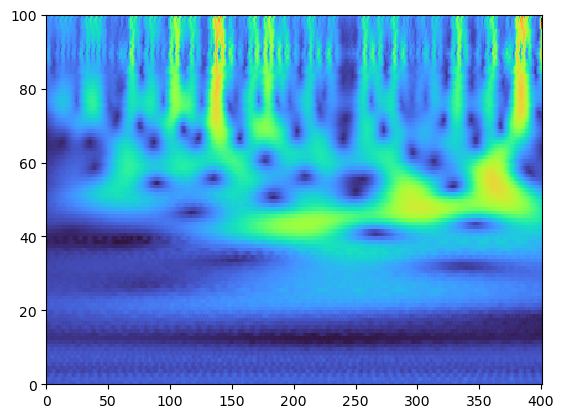

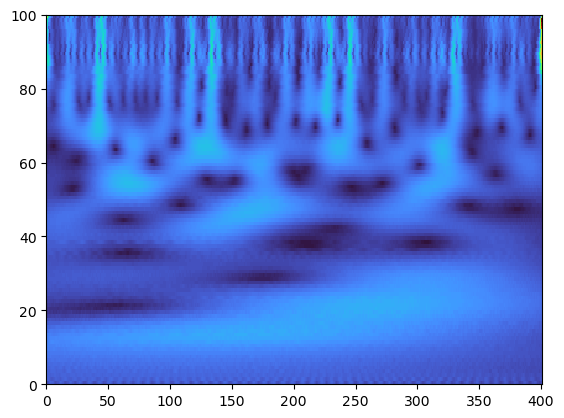

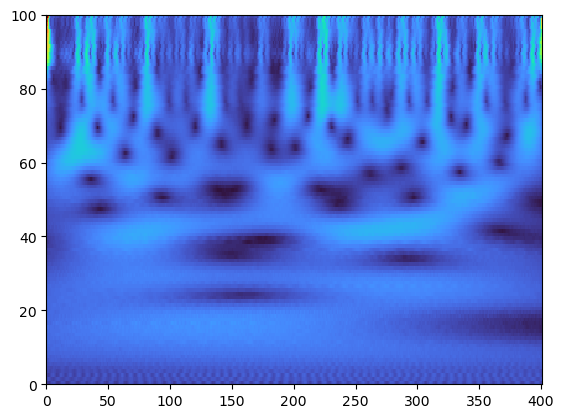

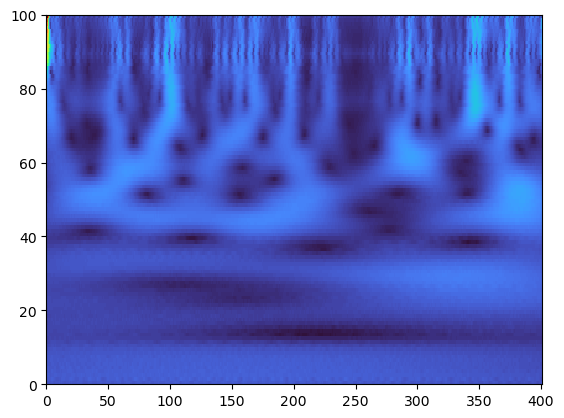

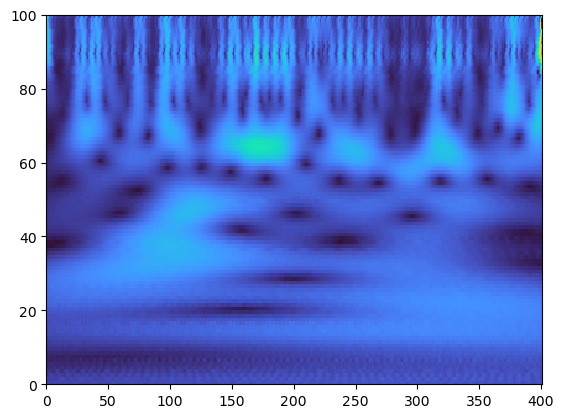

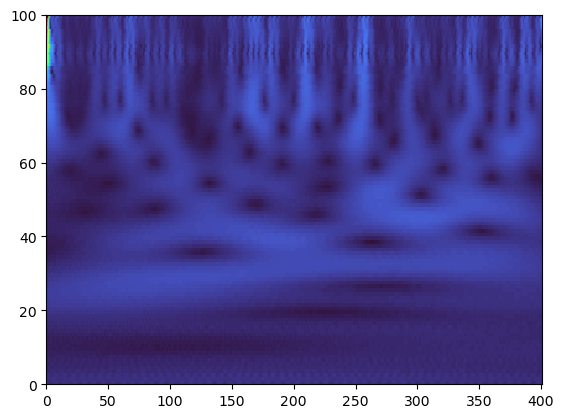

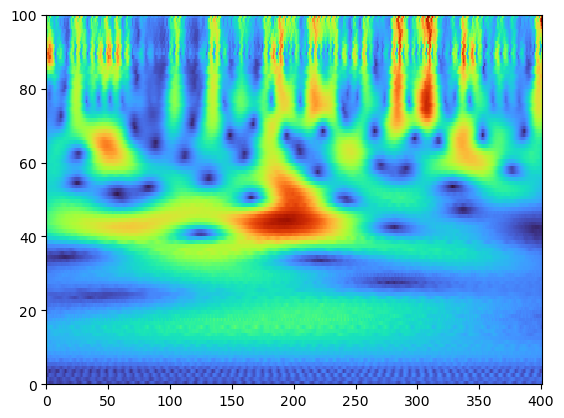

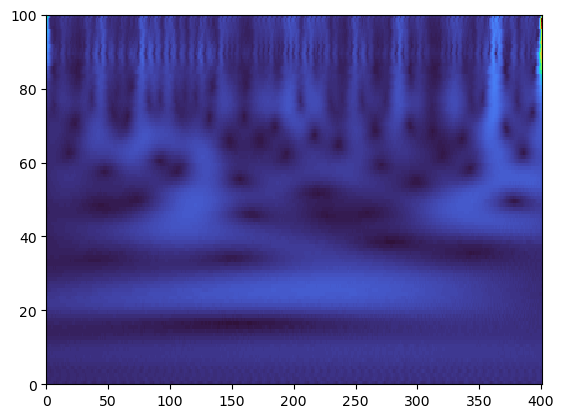

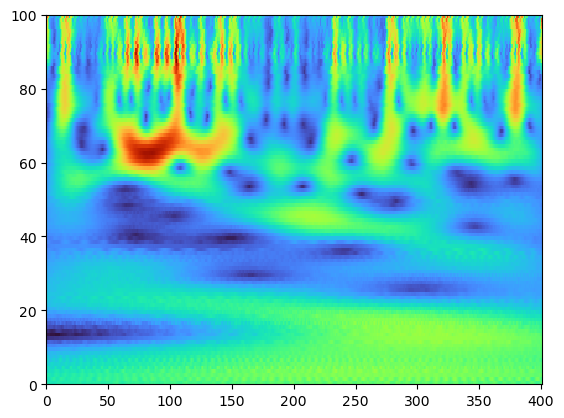

In [22]:
import matplotlib.pyplot as plt
for i in range(18):
    plt.pcolormesh(x[0][i], cmap="turbo")
    plt.show()